## Импорт бибилотек

In [1]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available')
else:
    print('CUDA is available!')

CUDA is available!


In [2]:
import numpy as np
from tqdm import tqdm, tqdm_notebook
from typing import Callable, Optional, Type
import cv2
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from matplotlib import colors, pyplot as plt
import torch
import torch.nn.functional as F
import torch.optim as optim
from dataclasses import dataclass
from torch.utils.data import DataLoader
from torch.optim import Adam, AdamW
import tqdm
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import pandas as pd
from datetime import datetime
from typing import Callable, Optional, Type
import torchmetrics

C:\Users\maxim\anaconda3\envs\MN\Lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
DATA_MODES = ['train', 'val', 'test']
SEED = 42
NUM_CLASSES = 10
IMG_SIZE = 224
BATCH_SIZE = 256

## 1) Формирование train/test/val

In [4]:
data = pd.read_csv('data.csv', index_col=0).reset_index(drop=True)

In [5]:
data['type'] = data['type'] - 1

In [6]:
data.head()

,file_path,x1,y1,x2,y2,type,type_name
0,.\data\CompCars\data\image\100\209\2009\0ff9e9...,95,85,817,626,0,minivan
1,.\data\CompCars\data\image\100\209\2009\103597...,223,163,704,548,0,minivan
2,.\data\CompCars\data\image\100\209\2009\1cb896...,95,100,849,606,0,minivan
3,.\data\CompCars\data\image\100\209\2009\35bc70...,54,137,837,613,0,minivan
4,.\data\CompCars\data\image\100\209\2009\398aad...,96,203,794,531,0,minivan


In [7]:
data.shape

(97842, 7)

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
train_val_df, test_df = train_test_split(
    data,
    test_size=0.2,
    stratify=data['type'],
    random_state=SEED
)

In [10]:
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.2,
    stratify=train_val_df['type'],
    random_state=SEED
)

In [11]:
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Train size: 62618
Validation size: 15655
Test size: 19569


## 2) Формирование даталоадеров

In [12]:
class AlbumentationsTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, img):
        img = np.array(img)
        augmented = self.transform(image=img)
        return augmented['image']

In [13]:
class CarsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, data, mode, img_size):
        super().__init__()
        self.data = data
        self.mode = mode
        self.img_size = img_size

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {config.DATA_MODES}")
            raise NameError

    def __len__(self):
        return len(self.data)

    def test_transforms(self):
        transforms = A.Compose([
            A.Resize(height=self.img_size, width=self.img_size, interpolation=cv2.INTER_LINEAR),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255),
            ToTensorV2()
        ])
        return transforms

    def train_transforms(self):
        transforms = A.Compose([
            A.Resize(height=self.img_size, width=self.img_size, interpolation=cv2.INTER_LINEAR),
            
            # Горизонтальное отражение
            A.HorizontalFlip(p=0.5),
        
            # Вращение от -40 до +40 градусов
            A.Rotate(limit=40, p=0.3),
        
            # Случайное изменение яркости и контраста
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
        
            # Эффект размытия
            A.Blur(blur_limit=(3, 7), p=0.3),
        
            # # Случайное зануление прямоугольных областей
            # A.CoarseDropout(max_holes=3, max_height=40, max_width=40, p=0.3),
            
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255),
            ToTensorV2()
        ])
        
        return transforms

    def __getitem__(self, index):
        row = self.data.iloc[index]
        img_path = row["file_path"]
        label = row["type"]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.mode == 'train':
            transforms = self.train_transforms()
            transform = AlbumentationsTransform(transform=transforms)
            image = transform(image)
        else:
            transforms = self.test_transforms()
            transform = AlbumentationsTransform(transform=transforms)
            image = transform(image)
        return image, torch.tensor(label, dtype=torch.long)

In [14]:
dataset = CarsDataset(data=data, mode='train', img_size=IMG_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

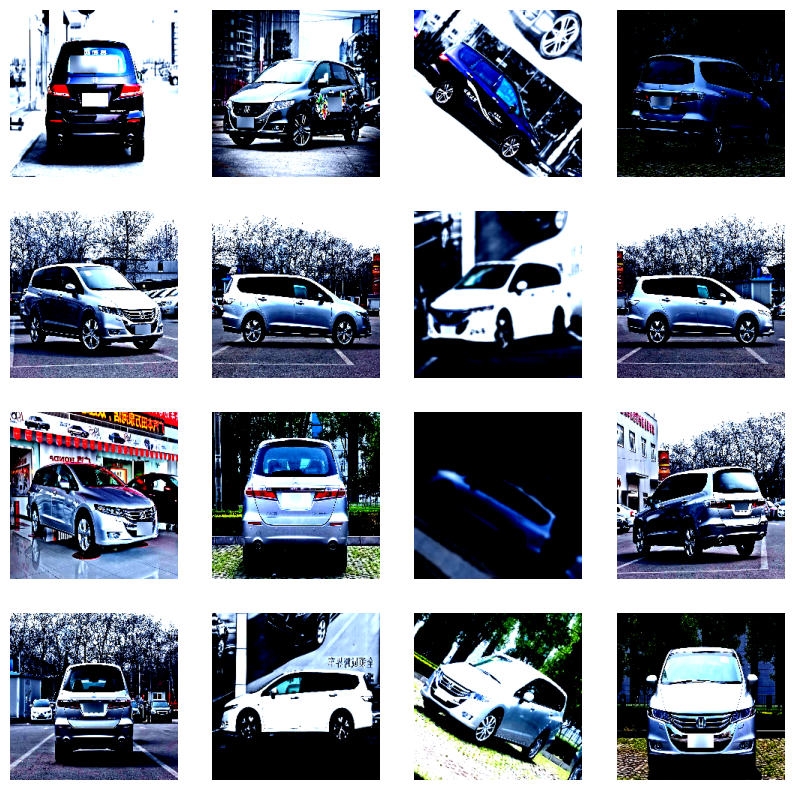

In [15]:
images = [dataset[i + 50][0] for i in range(16)]
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img = images[i].permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.axis('off')
plt.show()

In [16]:
train_dataset = CarsDataset(data=train_df, mode='train', img_size=IMG_SIZE)
val_dataset = CarsDataset(data=val_df, mode='val', img_size=IMG_SIZE)
test_dataset = CarsDataset(data=test_df, mode='test', img_size=IMG_SIZE)
train_labels = train_dataset.data['type']

In [17]:
print(f'Размер датасета train: {len(train_dataset)}')
print(f'Размер датасета test: {len(test_dataset)}')
print(f'Размер датасета val: {len(val_dataset)}')

Размер датасета train: 62618
Размер датасета test: 19569
Размер датасета val: 15655


In [18]:
from collections import Counter
from torch.utils.data import WeightedRandomSampler

In [19]:
Counter(train_labels)

Counter({2: 20655,
         1: 14562,
         3: 10606,
         0: 3935,
         9: 3854,
         4: 3026,
         8: 2253,
         5: 1583,
         7: 1366,
         6: 778})

In [20]:
len(train_labels)

62618

In [21]:
def make_weighted_loader(dataset, labels, batch_size, drop_last):
    """ Функция для семплирования с учетом дисбаланса классов """
    label_counts = Counter(labels)
    label_weights = {label: 1.0 / count for label, count in label_counts.items()}
    sample_weights = np.array([label_weights[label] for label in labels])
    num_samples = 5 * max(label_counts.values())
    sampler = WeightedRandomSampler(sample_weights, num_samples=num_samples, replacement=True)
    train_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        sampler=sampler,
        drop_last=drop_last
    )
    return train_loader

In [22]:
train_loader = make_weighted_loader(
    train_dataset,
    train_labels,
    batch_size=BATCH_SIZE,
    drop_last=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=True
)

## Определим функции сохранения и загрузки модели и оптимизатора

In [23]:
def save_checkpoint(
    model,
    optimizer,
    scheduler=None,
    step=None,
    best_f1=None,
    config=None,
    checkpoint_path='checkpoint.pt'
):
    checkpoint = {
        'optimizer_class': optimizer.__class__.__name__,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'step': step,
        'best_f1': best_f1,
        'config': Config,
    }
    torch.save(checkpoint, checkpoint_path)

In [24]:
def load_checkpoint(
    model,
    checkpoint_path='checkpoint.pt'
):
    checkpoint = torch.load(checkpoint_path)
    config = checkpoint.get('config', None)
    print(config)

    if config is None:
        raise ValueError("Config not found in the checkpoint. Please provide a valid checkpoint.")

    optimizer_class_name = checkpoint.get('optimizer_class', None)
    optimizer_class = getattr(optim, optimizer_class_name)
    optimizer = optimizer_class(model.parameters(), lr=config.lr)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    scheduler = None
    if config.scheduler:
        scheduler = config.scheduler(
            optimizer, 
            # step_size=config.scheduler_step_size, 
            # gamma=config.scheduler_gamma

            mode=config.scheduler_mode, 
            factor=config.scheduler_factor,
            patience=config.scheduler_patience
        )

        # Загрузка состояния планировщика, если оно есть в чекпоинте
        if checkpoint['scheduler_state_dict'] is not None:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    return {
        'model': model,
        'optimizer': optimizer,
        'scheduler': scheduler,
        'step': checkpoint.get('step', 0),
        'best_f1': checkpoint.get('best_f1', None),
        'config': config,
    }

In [25]:
@dataclass
class Config:
    # Общие параметры
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    tensorboard_log_dir: str = './logs'
    model_name: Optional[str] = 'default_name'

    # Обучение
    batch_size: int = 256
    n_epochs: int = 1
    eval_every: int = 200
    lr: float = 1e-4

    optimizer: Type[torch.optim.Optimizer] = torch.optim.AdamW
    loss_func: Callable[[torch.Tensor, torch.Tensor], torch.Tensor] = nn.CrossEntropyLoss()

    scheduler: Optional[Type[torch.optim.lr_scheduler._LRScheduler]] = torch.optim.lr_scheduler.ReduceLROnPlateau
    # scheduler_step_size: int = 1
    # scheduler_gamma: float = 0.5

    scheduler_mode: str = 'max'  # Снижать lr при увеличении ошибки
    scheduler_factor: float = 0.5  # Во сколько раз уменьшать lr
    scheduler_patience: int = 1  # Количество эпох без улучшения перед снижением lr

In [26]:
# Обучение baseline
# lr: float = 1e-3
# scheduler = None
# optimizer = torch.optim.Adam
# loss_func = nn.CrossEntropyLoss

## Напишем train loop

In [27]:
from torch.utils.tensorboard import SummaryWriter
from torchmetrics.classification import Precision, Recall, F1Score

In [28]:
def train_loop(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    config: Config | None = None,
    checkpoint: dict | None = None,
    name: str = None
):
    if config is None and checkpoint is None:
        raise ValueError("Config cannot be None when initializing without a checkpoint!")

    if checkpoint is not None:
        model = checkpoint['model']
        optimizer = checkpoint['optimizer']
        scheduler = checkpoint['scheduler']
        step = checkpoint['step']
        best_f1 = checkpoint['best_f1']
        config = checkpoint['config']
    else:
        optimizer = config.optimizer(model.parameters(), lr=config.lr, weight_decay=1e-4)
        scheduler_mode = config.scheduler_mode
        scheduler_factor = config.scheduler_factor
        scheduler_patience = config.scheduler_patience
        # scheduler_step_size = config.scheduler_step_size
        # scheduler_gamma = config.scheduler_gamma
        # scheduler = config.scheduler(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)
        scheduler = config.scheduler(optimizer, mode=scheduler_mode, factor=scheduler_factor, patience=scheduler_patience)
        step = 0
        best_f1 = -float('inf')

    loss_func = config.loss_func
    device = config.device

    if name is not None:
        experiment_name = name
    else:
        experiment_name = f"{config.model_name}_lr{config.lr}_epochs{config.n_epochs}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

    log_dir = f"{config.tensorboard_log_dir}/{experiment_name}"
    writer = SummaryWriter(log_dir=log_dir)

    # Метрики
    precision_metric = Precision(task='multiclass', num_classes=NUM_CLASSES, average='macro').to(device)
    recall_metric = Recall(task='multiclass', num_classes=NUM_CLASSES, average='macro').to(device)
    f1_metric = F1Score(task='multiclass', num_classes=NUM_CLASSES, average='macro').to(device)

    model.to(device)
    # Отправляем опитмизатор на девайс
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)
    model.train()
    for epoch in range(config.n_epochs):
        print(f"Epoch #{epoch + 1}/#{config.n_epochs}")

        for i, (img_batch, true_labels) in enumerate(tqdm.tqdm(train_loader)):
            step += 1
            img_batch, true_labels = img_batch.to(device), true_labels.to(device)
            true_labels = true_labels.to(torch.long)
            
            optimizer.zero_grad()
            pred_labels = model(img_batch)
            loss_train = loss_func(pred_labels, true_labels)
            loss_train.backward()
            optimizer.step()

            # Логирование метрик на обучении
            if step % 10 == 0:
                writer.add_scalar("Loss/Train", loss_train.item(), step)
            
            if (i + 1) % config.eval_every == 0:
                # Метрики на валидации
                model.eval()
                val_loss_total = 0.0
                precision_metric.reset()
                recall_metric.reset()
                f1_metric.reset()

                with torch.no_grad():
                    for i, (img_batch_val, true_labels_val) in enumerate(val_loader):
                        img_batch_val, true_labels_val = img_batch_val.to(device), true_labels_val.to(device)
                        outputs = model(img_batch_val)
                        loss_val = loss_func(outputs, true_labels_val)
                        val_loss_total += loss_val.item()

                        # Обновляем метрики
                        preds = torch.argmax(outputs, dim=1)
                        precision_metric.update(preds, true_labels_val)
                        recall_metric.update(preds, true_labels_val)
                        f1_metric.update(preds, true_labels_val)

                torch.cuda.empty_cache()

                avg_val_loss = val_loss_total / len(val_loader)
                precision = precision_metric.compute().item()
                recall = recall_metric.compute().item()
                f1 = f1_metric.compute().item()

                # Логирование на TensorBoard
                writer.add_scalar("Loss/Validation", avg_val_loss, step)
                writer.add_scalar("Metrics/Precision", precision, step)
                writer.add_scalar("Metrics/Recall", recall, step)
                writer.add_scalar("Metrics/F1", f1, step)

                print(f"Step {step}: Val Loss={avg_val_loss:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")
                if f1 > best_f1:
                    best_f1 = f1
                    save_checkpoint(
                        model=model,
                        optimizer=optimizer,
                        step=step,
                        best_f1=best_f1,
                        config=vars(config),
                        checkpoint_path=f"best_checkpoint_val_p_{precision:.4f}_r_{recall:.4f}_f1_{f1:.4f}.pt"
                    )
                    print(f"New best model saved with F1={f1:.4f}")
                model.train()


            save_checkpoint(
                model=model,
                optimizer=optimizer,
                step=step,
                best_f1=best_f1,
                config=vars(config),
                checkpoint_path='cur_checkpoint.pt'
            )
        if scheduler is not None:
            scheduler.step(f1)
        save_checkpoint(
            model=model,
            optimizer=optimizer,
            step=step,
            best_f1=best_f1,
            config=vars(config),
            checkpoint_path='epoch_checkpoint.pt'
        )
    # Закрытие TensorBoard
    writer.close()
    return optimizer

In [29]:
#from torchvision.models import resnet18

In [30]:
from torchvision.models import resnet34

C:\Users\maxim\anaconda3\envs\MN\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Не найдена указанная процедура'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Посмотрим на структуру resnet18

In [31]:
resnet = resnet34(weights='IMAGENET1K_V1')

In [32]:
list(resnet.children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

## Будем файнтюнить последний sequential block:

In [33]:
list(resnet.children())[-3]

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1

## Уберем последний линейный слой и добавим свой

In [34]:
class CustomResNet18(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()

        self.resnet = resnet34(weights='IMAGENET1K_V1')
        # Убрали последний линейный слой
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])

        # Сказали, что замораживаем всю сеть
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Размораживаем последний sequential block
        for param in list(self.resnet[-2].parameters()):
            param.requires_grad = True

        self.flatten = nn.Flatten()
        self.out = nn.Sequential(
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x = self.resnet(x)
        x = self.flatten(x)
        x = self.out(x)
        return x

In [35]:
model = CustomResNet18(num_classes=NUM_CLASSES)
print(model)

CustomResNet18(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [36]:
config_res18_last_seq = Config(
    model_name = 'try_start_train',
    batch_size = 256,
    n_epochs = 12,
    eval_every = 400,
    lr = 0.004
)

In [37]:
# !taskkill /IM "tensorboard.exe" /F
!rmdir /S /Q %temp%\.tensorboard-info

In [38]:
%load_ext tensorboard
%tensorboard --logdir $config_res18_last_seq.tensorboard_log_dir

In [39]:
# Инициализация модели
model = CustomResNet18(num_classes=NUM_CLASSES)

# Запуск обучения с нуля
res = train_loop(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    config=config_res18_last_seq,
    name="experiment_resnet18"
)

Epoch #1/#12


 99%|█████████▉| 399/403 [18:31<00:11,  2.86s/it]

Step 400: Val Loss=1.0833, Precision=0.6164, Recall=0.6636, F1=0.5857
New best model saved with F1=0.5857


100%|██████████| 403/403 [21:18<00:00,  3.17s/it]


Epoch #2/#12


 99%|█████████▉| 399/403 [19:13<00:12,  3.00s/it]

Step 803: Val Loss=0.9109, Precision=0.6559, Recall=0.7305, F1=0.6602
New best model saved with F1=0.6602


100%|██████████| 403/403 [22:07<00:00,  3.29s/it]


Epoch #3/#12


 99%|█████████▉| 399/403 [18:59<00:11,  2.79s/it]

Step 1206: Val Loss=0.7367, Precision=0.7232, Recall=0.7301, F1=0.7108


 99%|█████████▉| 400/403 [21:29<02:20, 46.77s/it]

New best model saved with F1=0.7108


100%|██████████| 403/403 [21:37<00:00,  3.22s/it]


Epoch #4/#12


 99%|█████████▉| 399/403 [18:52<00:11,  2.81s/it]

Step 1609: Val Loss=0.7332, Precision=0.6902, Recall=0.7714, F1=0.7159
New best model saved with F1=0.7159


100%|██████████| 403/403 [21:31<00:00,  3.20s/it]


Epoch #5/#12


 99%|█████████▉| 399/403 [18:34<00:10,  2.72s/it]

Step 2012: Val Loss=0.6247, Precision=0.7744, Recall=0.7421, F1=0.7537
New best model saved with F1=0.7537


100%|██████████| 403/403 [21:11<00:00,  3.15s/it]


Epoch #6/#12


 99%|█████████▉| 400/403 [21:05<02:23, 47.93s/it]

Step 2415: Val Loss=0.7924, Precision=0.7341, Recall=0.7672, F1=0.7270


100%|██████████| 403/403 [21:13<00:00,  3.16s/it]


Epoch #7/#12


 99%|█████████▉| 399/403 [18:57<00:11,  2.84s/it]

Step 2818: Val Loss=0.7623, Precision=0.7152, Recall=0.7545, F1=0.7180


100%|██████████| 403/403 [21:38<00:00,  3.22s/it]


Epoch #8/#12


 99%|█████████▉| 399/403 [18:33<00:11,  2.78s/it]

Step 3221: Val Loss=0.5992, Precision=0.8023, Recall=0.7802, F1=0.7879
New best model saved with F1=0.7879


100%|██████████| 403/403 [21:10<00:00,  3.15s/it]


Epoch #9/#12


 99%|█████████▉| 399/403 [18:27<00:11,  2.93s/it]

Step 3624: Val Loss=0.6085, Precision=0.8298, Recall=0.7783, F1=0.8001
New best model saved with F1=0.8001


100%|██████████| 403/403 [21:14<00:00,  3.16s/it]


Epoch #10/#12


 99%|█████████▉| 399/403 [18:59<00:11,  2.76s/it]

Step 4027: Val Loss=0.5753, Precision=0.8167, Recall=0.7966, F1=0.8052
New best model saved with F1=0.8052


100%|██████████| 403/403 [21:36<00:00,  3.22s/it]


Epoch #11/#12


 99%|█████████▉| 399/403 [18:45<00:11,  2.77s/it]

Step 4430: Val Loss=0.6102, Precision=0.8181, Recall=0.7894, F1=0.8012


100%|██████████| 403/403 [21:28<00:00,  3.20s/it]


Epoch #12/#12


 99%|█████████▉| 400/403 [21:12<02:18, 46.22s/it]

Step 4833: Val Loss=0.6477, Precision=0.8366, Recall=0.7684, F1=0.7932


100%|██████████| 403/403 [21:21<00:00,  3.18s/it]


In [40]:
# Продолжение обучения
model = CustomResNet18(num_classes=NUM_CLASSES)
checkpoint = load_checkpoint(model, checkpoint_path='cur_checkpoint.pt')

# Запуск дообучения
res = train_loop(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    checkpoint=checkpoint,
    name=f"continue_learn_"
)

<class '__main__.Config'>
Epoch #1/#1


 49%|████▉     | 199/403 [09:30<09:33,  2.81s/it]

Step 5036: Val Loss=0.6039, Precision=0.8244, Recall=0.8004, F1=0.8107
New best model saved with F1=0.8107


 99%|█████████▉| 400/403 [30:23<08:01, 160.34s/it] 

Step 5236: Val Loss=0.6111, Precision=0.8354, Recall=0.7919, F1=0.8103


100%|██████████| 403/403 [30:45<00:00,  4.58s/it] 


In [47]:
NUM_CLASSES = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint_path = "best_checkpoint_val_p_0.8244_r_0.8004_f1_0.8107.pt"
model = CustomResNet18(num_classes=NUM_CLASSES)

loaded_data = load_checkpoint(model, checkpoint_path=checkpoint_path)

model = loaded_data['model']

model.eval()

device = 'cuda'
model.to(device)

f1_metric = F1Score(task='multiclass', num_classes=NUM_CLASSES, average='macro').to(device)

with torch.no_grad():
    for i, (img_batch_val, true_labels_val) in enumerate(test_loader):
        img_batch_val, true_labels_val = img_batch_val.to(device), true_labels_val.to(device)
        outputs = model(img_batch_val)
        preds = torch.argmax(outputs, dim=1)
        f1_metric.update(preds, true_labels_val)

final_f1 = f1_metric.compute().item()
print(f"Final Average F1 Score: {final_f1:.4f}")

<class '__main__.Config'>
Final Average F1 Score: 0.8027
